### Import and Install

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install

!pip install sentencepiece
!pip install transformers
!pip install fairseq fastBPE 
!wget https://public.vinai.io/BERTweet_base_transformers.tar.gz
!tar -xzvf BERTweet_base_transformers.tar.gz

     |████████████████████████████████| 1.2 MB 5.2 MB/s 
     |████████████████████████████████| 3.1 MB 5.4 MB/s 
     |████████████████████████████████| 3.3 MB 37.6 MB/s 
     |████████████████████████████████| 895 kB 39.3 MB/s 
     |████████████████████████████████| 596 kB 45.5 MB/s 
     |████████████████████████████████| 59 kB 6.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.7 MB 5.3 MB/s 
     |████████████████████████████████| 90 kB 8.5 MB/s 
     |████████████████████████████████| 145 kB 44.2 MB/s 
     |████████████████████████████████| 74 kB 3.0 MB/s 
     |████████████████████████████████| 112 kB 46.4 MB/s 
  Created wheel for fastBPE: filename=fastBPE-0.1.0-cp37-cp37m-linux_x86_64.whl size=483096 sha256=d1a9da012f65f3959ea1e06f5a4e61b2fa557f0472f7d8adc49b05d0ccc856fb
  Stored in directory: /root/.cache/pip/wheels/bd/d4/0e/0d

--2021-11-18 21:09:57--  https://public.vinai.io/BERTweet_base_transformers.tar.gz
Resolving public.vinai.io (public.vinai.io)... 65.8.49.107, 65.8.49.115, 65.8.49.47, ...
Connecting to public.vinai.io (public.vinai.io)|65.8.49.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322076118 (307M) [application/x-tar]
Saving to: ‘BERTweet_base_transformers.tar.gz’

BERTweet_base_trans 100%[===================>] 307.16M  13.8MB/s    in 22s     

2021-11-18 21:10:21 (13.9 MB/s) - ‘BERTweet_base_transformers.tar.gz’ saved [322076118/322076118]

BERTweet_base_transformers/
BERTweet_base_transformers/config.json
BERTweet_base_transformers/bpe.codes
BERTweet_base_transformers/model.bin
BERTweet_base_transformers/dict.txt


In [3]:
# Import Libs
import pandas as pd, numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold
import tokenizers
from transformers import RobertaConfig, TFRobertaModel
print('TF version',tf.__version__)

from types import SimpleNamespace
from fairseq.data.encoders.fastbpe import fastBPE
from fairseq.data import Dictionary
from sklearn.utils import shuffle

import json
import os
import tensorflow as tf
import csv
import random
import numpy as np
import sklearn
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

TF version 2.7.0


## Define Model

In [4]:
class BERTweetTokenizer():
    
    def __init__(self,pretrained_path = '/content/BERTweet_base_transformers/'):
        
        self.bpe = fastBPE(SimpleNamespace(bpe_codes= pretrained_path + "bpe.codes"))
        self.vocab = Dictionary()
        self.vocab.add_from_file(pretrained_path + "dict.txt")
        self.cls_token_id = 0
        self.pad_token_id = 1
        self.sep_token_id = 2
        self.pad_token = '<pad>'
        self.cls_token = '<s>'
        self.sep_token = '</s>'
        
    def bpe_encode(self,text):
        return self.bpe.encode(text) # bpe.encode(line)
    
    def encode(self,text,add_special_tokens=False):
        subwords = self.bpe.encode(text)
        input_ids = self.vocab.encode_line(subwords, append_eos=False, add_if_not_exist=False).long().tolist() ## Map subword tokens to corresponding indices in the dictionary
        return input_ids
    
    def tokenize(self,text):
        return self.bpe_encode(text).split()
    
    def convert_tokens_to_ids(self,tokens):
        input_ids = self.vocab.encode_line(' '.join(tokens), append_eos=False, add_if_not_exist=False).long().tolist()
        return input_ids
    
    #from: https://www.kaggle.com/nandhuelan/bertweet-first-look
    def decode_id(self,id):
        return self.vocab.string(id, bpe_symbol = '@@')
    
    def decode_id_nospace(self,id):
        return self.vocab.string(id, bpe_symbol = '@@ ')

    def bert_encode(self, texts, max_len=512):
        all_tokens = []
        all_masks = []
        all_segments = []
        
        for text in texts:
            text = self.bpe.encode(text)
            input_sequence = '<s> ' + text + ' </s>'

            enc = self.vocab.encode_line(input_sequence, append_eos=False, add_if_not_exist=False).long().tolist()   
            enc = enc[:max_len-2]
            
            pad_len = max_len - len(enc)
            
            tokens = enc + [1] * pad_len #input_ids
            pad_masks = [1] * len(enc) + [0] * pad_len #attention_mask
            segment_ids = [0] * max_len #token_type_ids
            
            all_tokens.append(tokens)
            all_masks.append(pad_masks)
            all_segments.append(segment_ids)
        
        return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [5]:
def build_model(max_len=512):
    PATH = '/content/BERTweet_base_transformers/'
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    config = RobertaConfig.from_pretrained(PATH+'config.json')
    bert_model = TFRobertaModel.from_pretrained(PATH+'model.bin',config=config,from_pt=True)
    x = bert_model(input_word_ids,attention_mask=input_mask,token_type_ids=segment_ids)

    #pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    #clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(x[0]) 
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Flatten()(net)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

    #print(out.shape)
    
    return model

In [6]:
df = pd.read_csv('/content/drive/Shareddrives/Projeto IBRA USP/Coleta de Dados/Datasets - IBRA/E1 - Hate Speech and Offensive Language/labeled_data.csv', dtype={'Class': int, 'Tweet': str})
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


## Class Pre-processing
 
Creating the necessary columns to analyze the model.

#### Binary Class to Hate speech

A class will be created that will have a value of 1 if it is offensive language or hate speech, and zero if it is not.


In [7]:
def binaryClassHateSpeech(dataframe, mod=1):
  if(mod == 1): #Put together hate speech and Ofensive language
    dataframe['hate_ofencive_speech'] = dataframe['class'].apply(lambda x: 1 if x!=2 else 0)
  
  if(mod == 2): # It take just the hate speech
    dataframe['hate_ofencive_speech'] = dataframe['class'].apply(lambda x: 1 if x==0 else 0)
  
  return dataframe

In [8]:
df = binaryClassHateSpeech(df)

In [9]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,hate_ofencive_speech
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,0
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


## Cross Validation

In [10]:
# Cria o objeto
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)

In [11]:
# Transform series to numpy
X_df = df['tweet'].to_numpy()
print(len(X_df))
categories = df['hate_ofencive_speech'].to_numpy()
print(len(categories))

24783
24783


In [12]:
import torch
import gc
import time

threshold = 0.55
max_len = 32

df_cross_validation_metrics = pd.DataFrame(columns = ['TP', 'TN', 'FP','FN', 'Accuracy', 'Precision', 'Recall', 'FbetaScore'])

test_loop = []
train_loop = []

In [13]:
import pickle

def save_dict_to_pickle(data, path):
  with open(path, 'wb') as fp:
      pickle.dump(data, fp, protocol=pickle.HIGHEST_PROTOCOL)
      fp.close()

def open_pickle_to_dict (file):
  with open(file, 'rb') as fp:
      new_dict = pickle.load(fp)
      fp.close()
      return new_dict

test_path = '/content/drive/Shareddrives/Projeto IBRA USP/Coleta de Dados/Códigos/part1test'
os.chdir(test_path)

In [14]:
iter = 0

for train_index, test_index in skf.split(X_df, categories):

  test_loop.insert(iter, test_index)
  train_loop.insert(iter, train_index)
  iter = iter + 1

In [15]:
i = 4

# make directory 
try:
    fold_path = f"{test_path}/fold {i}"
    os.mkdir(fold_path)
except:
    print("Path already exists.")

# cleaning GPU cache and RAM
torch.cuda.empty_cache()
gc.collect()   

# Building model
model = build_model(max_len=max_len)
print(f"Running fold {i}...")

train = df.loc[train_loop[i],:]
test = df.loc[test_loop[i],:]

train_y_list = train['hate_ofencive_speech'].to_numpy()
test_y_list = test['hate_ofencive_speech'].to_numpy()

# Saving Metadata
metadata = {
    "train_indexes": train_loop[i],
    "test_indexes": test_loop[i],
    "training_size": len(train_y_list),
    "test_size": len(test_y_list),
    "fold_index": i
}

save_dict_to_pickle(metadata,test_path + '/fold ' + str(i) +'/metadata.p')

# Tokenization
tokenizer = BERTweetTokenizer()
X_train = tokenizer.bert_encode(train['tweet'], max_len=max_len)
X_test = tokenizer.bert_encode(test['tweet'], max_len=max_len)

# Training 
t0 = time.time()
train_history = model.fit(
  X_train, train_y_list, 
  epochs=3,
  batch_size=16,
  verbose=1
)
t1 = time.time()

print(f"Training done in {t1-t0}s")

# Predicting 
t0 = time.time()
P_hat = model.predict(X_test)
t1 = time.time()

print(f"Testing done in {t1-t0}s")

y_pred = np.where(P_hat > threshold, 1, 0)

test['Prediction'] = pd.DataFrame(np.squeeze(P_hat))
test['Classification'] = pd.DataFrame(y_pred)

test.to_csv(test_path + '/fold ' + str(i) +'/test.csv')
train.to_csv(test_path + '/fold ' + str(i) +'/train.csv')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
/usr/local/lib/python3.7/dist-packages/keras/opt

Running fold 4...
Epoch 1/3
1240/1240 [==============================] - 364s 278ms/step - loss: 0.2134 - accuracy: 0.9130
Epoch 2/3
1240/1240 [==============================] - 345s 279ms/step - loss: 0.1181 - accuracy: 0.9532
Epoch 3/3
1240/1240 [==============================] - 345s 278ms/step - loss: 0.0901 - accuracy: 0.9665
Training done in 1061.2982692718506s
Testing done in 28.456645727157593s


## Getting results

In [16]:
folds = list(range(5))
df_result_test = pd.DataFrame(columns = ['count',	'hate_speech',	'offensive_language',	'neither',	'class',	'tweet',	'hate_ofencive_speech'])
metadata_array = []

for i in folds :
  result_test = pd.read_csv('/content/drive/Shareddrives/Projeto IBRA USP/Coleta de Dados/Códigos/part1test/fold '+ str(i) +'/test.csv')
  result_test['fold'] = int(i)
  df_result_test = pd.concat([df_result_test, result_test])
  metadata_array.insert(i, open_pickle_to_dict('/content/drive/Shareddrives/Projeto IBRA USP/Coleta de Dados/Códigos/part1test/fold '+ str(i) +'/metadata.p'))


In [17]:
df_result_test.head()

,count,hate_speech,offensive_language,neither,class,tweet,hate_ofencive_speech,Unnamed: 0,Unnamed: 0.1,Prediction,Classification,fold
0,3,0,2,1,1,""" So hoes that smoke are losers ? "" yea ... go...",1,12.0,12.0,0.999759,1.0,0.0
1,3,0,3,0,1,""" bitch nigga miss me with it """,1,15.0,15.0,0.994552,1.0,0.0
2,3,0,3,0,1,""" broke bitch cant tell me nothing """,1,20.0,20.0,0.999832,1.0,0.0
3,3,0,2,1,1,""" her pussy lips like Heaven doors "" &#128524;",1,25.0,25.0,0.999866,1.0,0.0
4,3,0,3,0,1,""" jus meet son now he ya mane ass bitches "" #S...",1,37.0,37.0,0.999804,1.0,0.0


## Analysing Results



In [24]:
def plot_confusion_matrix(y, y_pred, beta = 1):
    """
    It receives an array with the ground-truth (y)
    and another with the prediction (y_pred), both with binary labels
    (positve=+1 and negative=-1) and plots the confusion
    matrix.
    It uses P (positive class id) and N (negative class id)
    which are "global" variables ...
    """
    TP = np.sum((y_pred == 1) * (y == 1))
    TN = np.sum((y_pred == 0) * (y == 0))

    FP = np.sum((y_pred == 1) * (y == 0))
    FN = np.sum((y_pred == 0) * (y == 1))

    total = TP+FP+TN+FN

    accuracy = (TP+TN)/total
    recall = (TP)/(TP+FN)
    precision = (TP)/(TP+FP)

    Fbeta = (precision*recall)*(1+beta**2)/(beta**2*precision + recall)
    
    print("TP = %4d    FP = %4d\nFN = %4d    TN = %4d\n"%(TP,FP,FN,TN))
    print("Accuracy = %d / %d (%f)" %((TP+TN),total, (TP+TN)/total))
    print("Recall = %d / %d (%f)" %((TP),(TP+FN), (TP)/(TP+FN)))
    print("Precision = %d / %d (%f)" %((TP),(TP+FP), (TP)/(TP+FP)))
    print("Fbeta Score = %f" %(Fbeta))

    confusion = [
        [TP/(TP+FN), FP/(TN+FP)],
        [FN/(TP+FN), TN/(TN+FP)]
    ]

    P = 1
    N = 0

    df_cm = pd.DataFrame(confusion, \
                         ['$\hat{y} = %d$'%P, '$\hat{y} = %d$'%N],\
                         ['$y = %d$'%P, '$y = %d$'%N])
    
    plt.figure(figsize = (8,4))
    sb.set(font_scale=1.4)
    sb.heatmap(df_cm, annot=True) #, annot_kws={"size": 16}, cmap = 'coolwarm')
    plt.show()

In [27]:
# Calculando métricas
def get_metrics (y, y_pred, beta = 1) :
  TP = np.sum((y_pred == 1) * (y == 1))
  TN = np.sum((y_pred == 0) * (y == 0))

  FP = np.sum((y_pred == 1) * (y == 0))
  FN = np.sum((y_pred == 0) * (y == 1))

  total = TP+FP+TN+FN

  accuracy = (TP+TN)/total
  recall = (TP)/(TP+FN)
  precision = (TP)/(TP+FP)

  Fbeta = (precision*recall)*(1+beta**2)/(beta**2*precision + recall)

  return ([TP, TN, FP,FN, accuracy, precision, recall, Fbeta])

In [21]:
# Metadata
folds = list(range(5))
for i in folds :
  print(metadata_array[i])

{'train_indexes': array([    1,     2,     3, ..., 24780, 24781, 24782]), 'test_indexes': array([    0,     4,     7, ..., 24758, 24768, 24775]), 'training_size': 19826, 'test_size': 4957, 'fold_index': 0}
{'train_indexes': array([    1,     2,     3, ..., 24780, 24781, 24782]), 'test_indexes': array([    0,     4,     7, ..., 24758, 24768, 24775]), 'training_size': 19826, 'test_size': 4957, 'fold_index': 1}
{'train_indexes': array([    1,     2,     3, ..., 24780, 24781, 24782]), 'test_indexes': array([    0,     4,     7, ..., 24758, 24768, 24775]), 'training_size': 19826, 'test_size': 4957, 'fold_index': 2}
{'train_indexes': array([    1,     2,     3, ..., 24780, 24781, 24782]), 'test_indexes': array([    0,     4,     7, ..., 24758, 24768, 24775]), 'training_size': 19827, 'test_size': 4956, 'fold_index': 3}
{'train_indexes': array([    1,     2,     3, ..., 24780, 24781, 24782]), 'test_indexes': array([    0,     4,     7, ..., 24758, 24768, 24775]), 'training_size': 19827, 'test_

/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

TP =  699    FP =  127
FN =  120    TN =   25

Accuracy = 724 / 971 (0.745623)
Recall = 699 / 819 (0.853480)
Precision = 699 / 826 (0.846247)
Fbeta Score = 0.852023


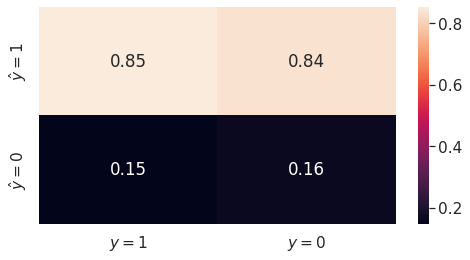

/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

TP =  674    FP =  130
FN =  133    TN =   29

Accuracy = 703 / 966 (0.727743)
Recall = 674 / 807 (0.835192)
Precision = 674 / 804 (0.838308)
Fbeta Score = 0.835813


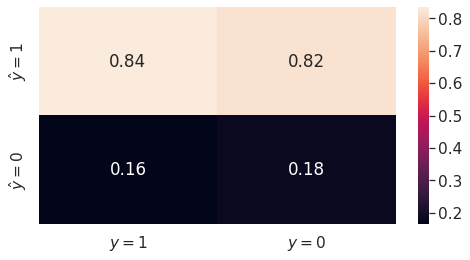

/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

TP =  672    FP =  151
FN =  120    TN =   29

Accuracy = 701 / 972 (0.721193)
Recall = 672 / 792 (0.848485)
Precision = 672 / 823 (0.816525)
Fbeta Score = 0.841894


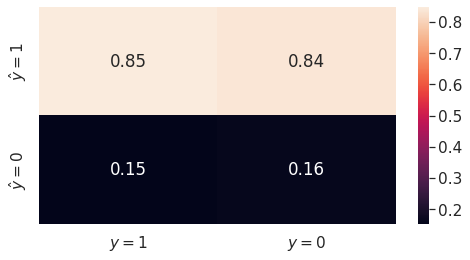

/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

TP =  722    FP =  138
FN =  139    TN =   20

Accuracy = 742 / 1019 (0.728165)
Recall = 722 / 861 (0.838560)
Precision = 722 / 860 (0.839535)
Fbeta Score = 0.838755


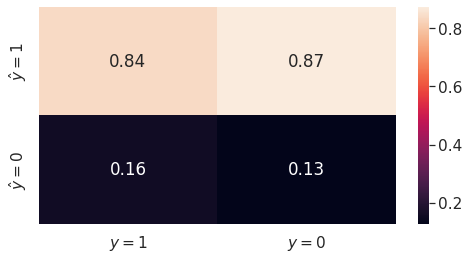

/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

TP =  696    FP =  159
FN =  143    TN =   31

Accuracy = 727 / 1029 (0.706511)
Recall = 696 / 839 (0.829559)
Precision = 696 / 855 (0.814035)
Fbeta Score = 0.826407


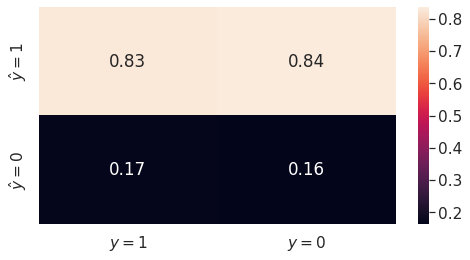

/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

In [28]:
# Metrics
beta = 2
folds = list(range(5))
df_metrics = pd.DataFrame(columns = ['TP', 'TN', 'FP','FN', 'accuracy', 'precision', 'recall', 'Fbeta'])

for i in folds :
  df_plot = df_result_test.loc[df_result_test['fold'] == i]
  plot_confusion_matrix(df_plot['hate_ofencive_speech'], df_plot['Classification'], beta)
  df_metrics.loc[len(df_metrics)] = get_metrics(df_plot['hate_ofencive_speech'], df_plot['Classification'], beta)

In [29]:
df_metrics

,TP,TN,FP,FN,accuracy,precision,recall,Fbeta
0,699.0,25.0,127.0,120.0,0.745623,0.846247,0.853480,0.852023
1,674.0,29.0,130.0,133.0,0.727743,0.838308,0.835192,0.835813
2,672.0,29.0,151.0,120.0,0.721193,0.816525,0.848485,0.841894
3,722.0,20.0,138.0,139.0,0.728165,0.839535,0.838560,0.838755
4,696.0,31.0,159.0,143.0,0.706511,0.814035,0.829559,0.826407


In [36]:
df_metrics_summary = pd.DataFrame(df_metrics.mean(), columns = ['mean'])
df_metrics_summary.insert(1, 'standard deviation', df_metrics.std())
df_metrics_summary

,mean,standard deviation
TP,692.600000,20.537770
TN,26.800000,4.381780
FP,141.000000,13.693064
FN,131.000000,10.653638
accuracy,0.725847,0.014103
precision,0.830930,0.014629
recall,0.841055,0.009777
Fbeta,0.838979,0.009311


In [32]:
df_metrics.std()

TP           20.537770
TN            4.381780
FP           13.693064
FN           10.653638
accuracy      0.014103
precision     0.014629
recall        0.009777
Fbeta         0.009311
dtype: float64